# Figure 11
Back trajectory data run from HYSPLIT version 5.2 (release date January 2022). This was originally run on a Windows PC and for completeness, the original input files are archived along with the data in the folder back_trajectory_control. They were run with the hyts_std.exe programme. Back trajectories were chosen so that they would be at regular intervals through each filter leg. Back trajectory output is stored in the back_trajectory_data file.

In [1]:
from glob import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.shapereader import Reader
import matplotlib.path as mpath
from cartopy.feature import ShapelyFeature

In [2]:
from matplotlib.collections import PathCollection

In [3]:
def read_tdump(file, days):
    with open(file, 'r') as f:
        lines = f.readlines()[10:]
    lats, lons, alts = [], [], []
    for line in lines:
        split = line.split()
        lat, lon, alt = float(split[-4]), float(split[-3]), float(split[-2])
        lats.append(lat)
        lons.append(lon)
        alts.append(alt)
        if int(float(split[-5])) == days * -24:
            break
    return lats, lons, alts

In [4]:
def convert_time_to_spm(time_str):
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

In [5]:
param = pd.read_csv('/home/users/erinraif/acao_data/metadata/parametrisations_v2.csv', index_col='unique_ID')
param = param.drop('c272r6t')

In [6]:
concs = pd.read_csv('/home/users/erinraif/acao_data/inp_data/subtracted_backgrounds_v4_2ul.csv', index_col='temp_bin')
# Assuming df is your DataFrame
filtered_columns = [col for col in concs.columns if col.endswith('_NT')]
concs = concs[filtered_columns]
concs = concs.drop(columns='c272r6t_NT')
concs_at_15 = concs.loc[-15,:]

In [8]:
def make_map(ax, PC, NPS, add=True):
    # Create background of maps on subplot
    ax.set_extent([-180,180,50,90],crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs = ccrs.PlateCarree(),zorder = 6, draw_labels = False,
                          linewidth = 0.5, linestyle = (0, (5, 1)), alpha = 0.9)
    gl.ylocator =  mticker.FixedLocator(np.arange(40,90,5))
    gl.xlocator =  mticker.FixedLocator(np.arange(-180,180,30))
    if add:
        # Paths to the sea-ice shapefiles for the maximum and minimum sea-ice extent
        max_ice_path = '/home/users/erinraif/acao_data/sea_ice_shapefiles/20220311_c271/masie_ice_r00_v01_2022070_1km.shp'
        min_ice_path = '/home/users/erinraif/acao_data/sea_ice_shapefiles/20220330_c281_c282/masie_ice_r00_v01_2022089_1km.shp'
        
        # Define coastlines, oceans and land shapes
        coasts_50m = cfeature.NaturalEarthFeature('physical', 'coastline', '50m', 
                                                  edgecolor='black',
                                                  facecolor= 'none')
        
        ocean_50m = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                                                edgecolor='face',
                                                facecolor='lightblue')
        
        land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                                edgecolor='face',
                                                facecolor='lightgray')
        
        #Create sea-ice features
        max_ice = cfeature.ShapelyFeature(Reader(max_ice_path).geometries(),
                                                 ccrs.NorthPolarStereo(central_longitude = -80, 
                                                 true_scale_latitude = 60), facecolor = 'azure',
                                                 edgecolors = 'red', linestyle='--')
        
        min_ice = cfeature.ShapelyFeature(Reader(min_ice_path).geometries(),
                                                 ccrs.NorthPolarStereo(central_longitude = -80, 
                                                 true_scale_latitude = 60), facecolor = 'azure',
                                                 edgecolors = 'red')
    
        # add all to the map
        ax.add_feature(ocean_50m, zorder = 1, alpha = 0.4)
        ax.add_feature(max_ice, zorder = 3, linewidth = 0.5)
        ax.add_feature(min_ice, zorder = 2, linewidth = 0.5)
        ax.add_feature(land_50m, zorder = 4, alpha = 0.4)
        ax.add_feature(coasts_50m, zorder = 5, linewidth = 0.5)

    return ax

In [11]:
def plot_trajectories_for_n_days(ndays,add=False):
    # set normalisations for colorbars
    alt_norm = plt.Normalize(0, 4000)
    alt_cm = plt.cm.viridis
    alt_sm = plt.cm.ScalarMappable(cmap=alt_cm, norm=alt_norm) 
    
    nu_norm = mpl.colors.LogNorm(0.1, 3)
    nu_cm = plt.cm.inferno
    nu_sm = plt.cm.ScalarMappable(cmap=nu_cm, norm=nu_norm)
    NPS = ccrs.NorthPolarStereo(central_longitude=0)
    PC = ccrs.PlateCarree()
    fig, (ax1, ax2) = plt.subplots(figsize=(10,6), dpi=300, ncols=2, nrows=1,
                       subplot_kw=dict(projection=NPS))
    for ax in (ax1, ax2):
            ax = make_map(ax, PC, NPS, add)
    # loop through all the samples and plot trajectories with appropriate colours
    for row in concs_at_15.index:     
        trajectory_files = glob(os.path.join('/home/users/erinraif/acao_data/back_trajectory_10day_data',
                                     'tdump_10day_' + row[:4]+'_run_'+row[5]+'*'))
        # pick a couple of trajectories from each sampling period to not overwhelm the viewer
        for traj_file in trajectory_files[::3]:
            lat, lon, alt = read_tdump(traj_file,ndays)
            avg_alts = [(alt[i] + alt[i + 1]) / 2 for i in range(len(alt) - 1)]
            # plot each hour of transport according to the altitude at the start
            for i in range(len(lat) - 1):
                color = alt_cm(alt_norm(avg_alts[i]))
                ax1.plot([lon[i], lon[i + 1]], [lat[i], lat[i + 1]],
                         color=color, transform=PC.as_geodetic(), zorder=10)
            ax2.plot(lon, lat, color=nu_cm(nu_norm(concs_at_15[row])),
                    linewidth = 1.5, transform = PC.as_geodetic(),
                    zorder =10)
    # create plot decorations
    ax1.text(0.03, 0.97, 'a.', ha='left', va='top', fontsize=20,
           transform=ax1.transAxes)
    ax2.text(0.03, 0.97, 'b.', ha='left', va='top', fontsize=20,
           transform=ax2.transAxes)
    cb1 = fig.colorbar(alt_sm, ax=ax1, fraction=0.046, pad=0.05, orientation="horizontal",
                      extend='max')
    cb1.set_label('Altitude / m', fontsize=14)
    cb2 = fig.colorbar(nu_sm, ax=ax2, fraction=0.046, pad=0.05, orientation="horizontal",
                      extend='min',format=mpl.ticker.ScalarFormatter(),ticks=[0.1,0.2,0.3,0.5,0.7,1,2,3])
    cb2.set_label(r'$N_{\mathrm{INP}}(T=-15^{\circ}\mathrm{C})$',fontsize=14)
    fig.tight_layout()
    return fig

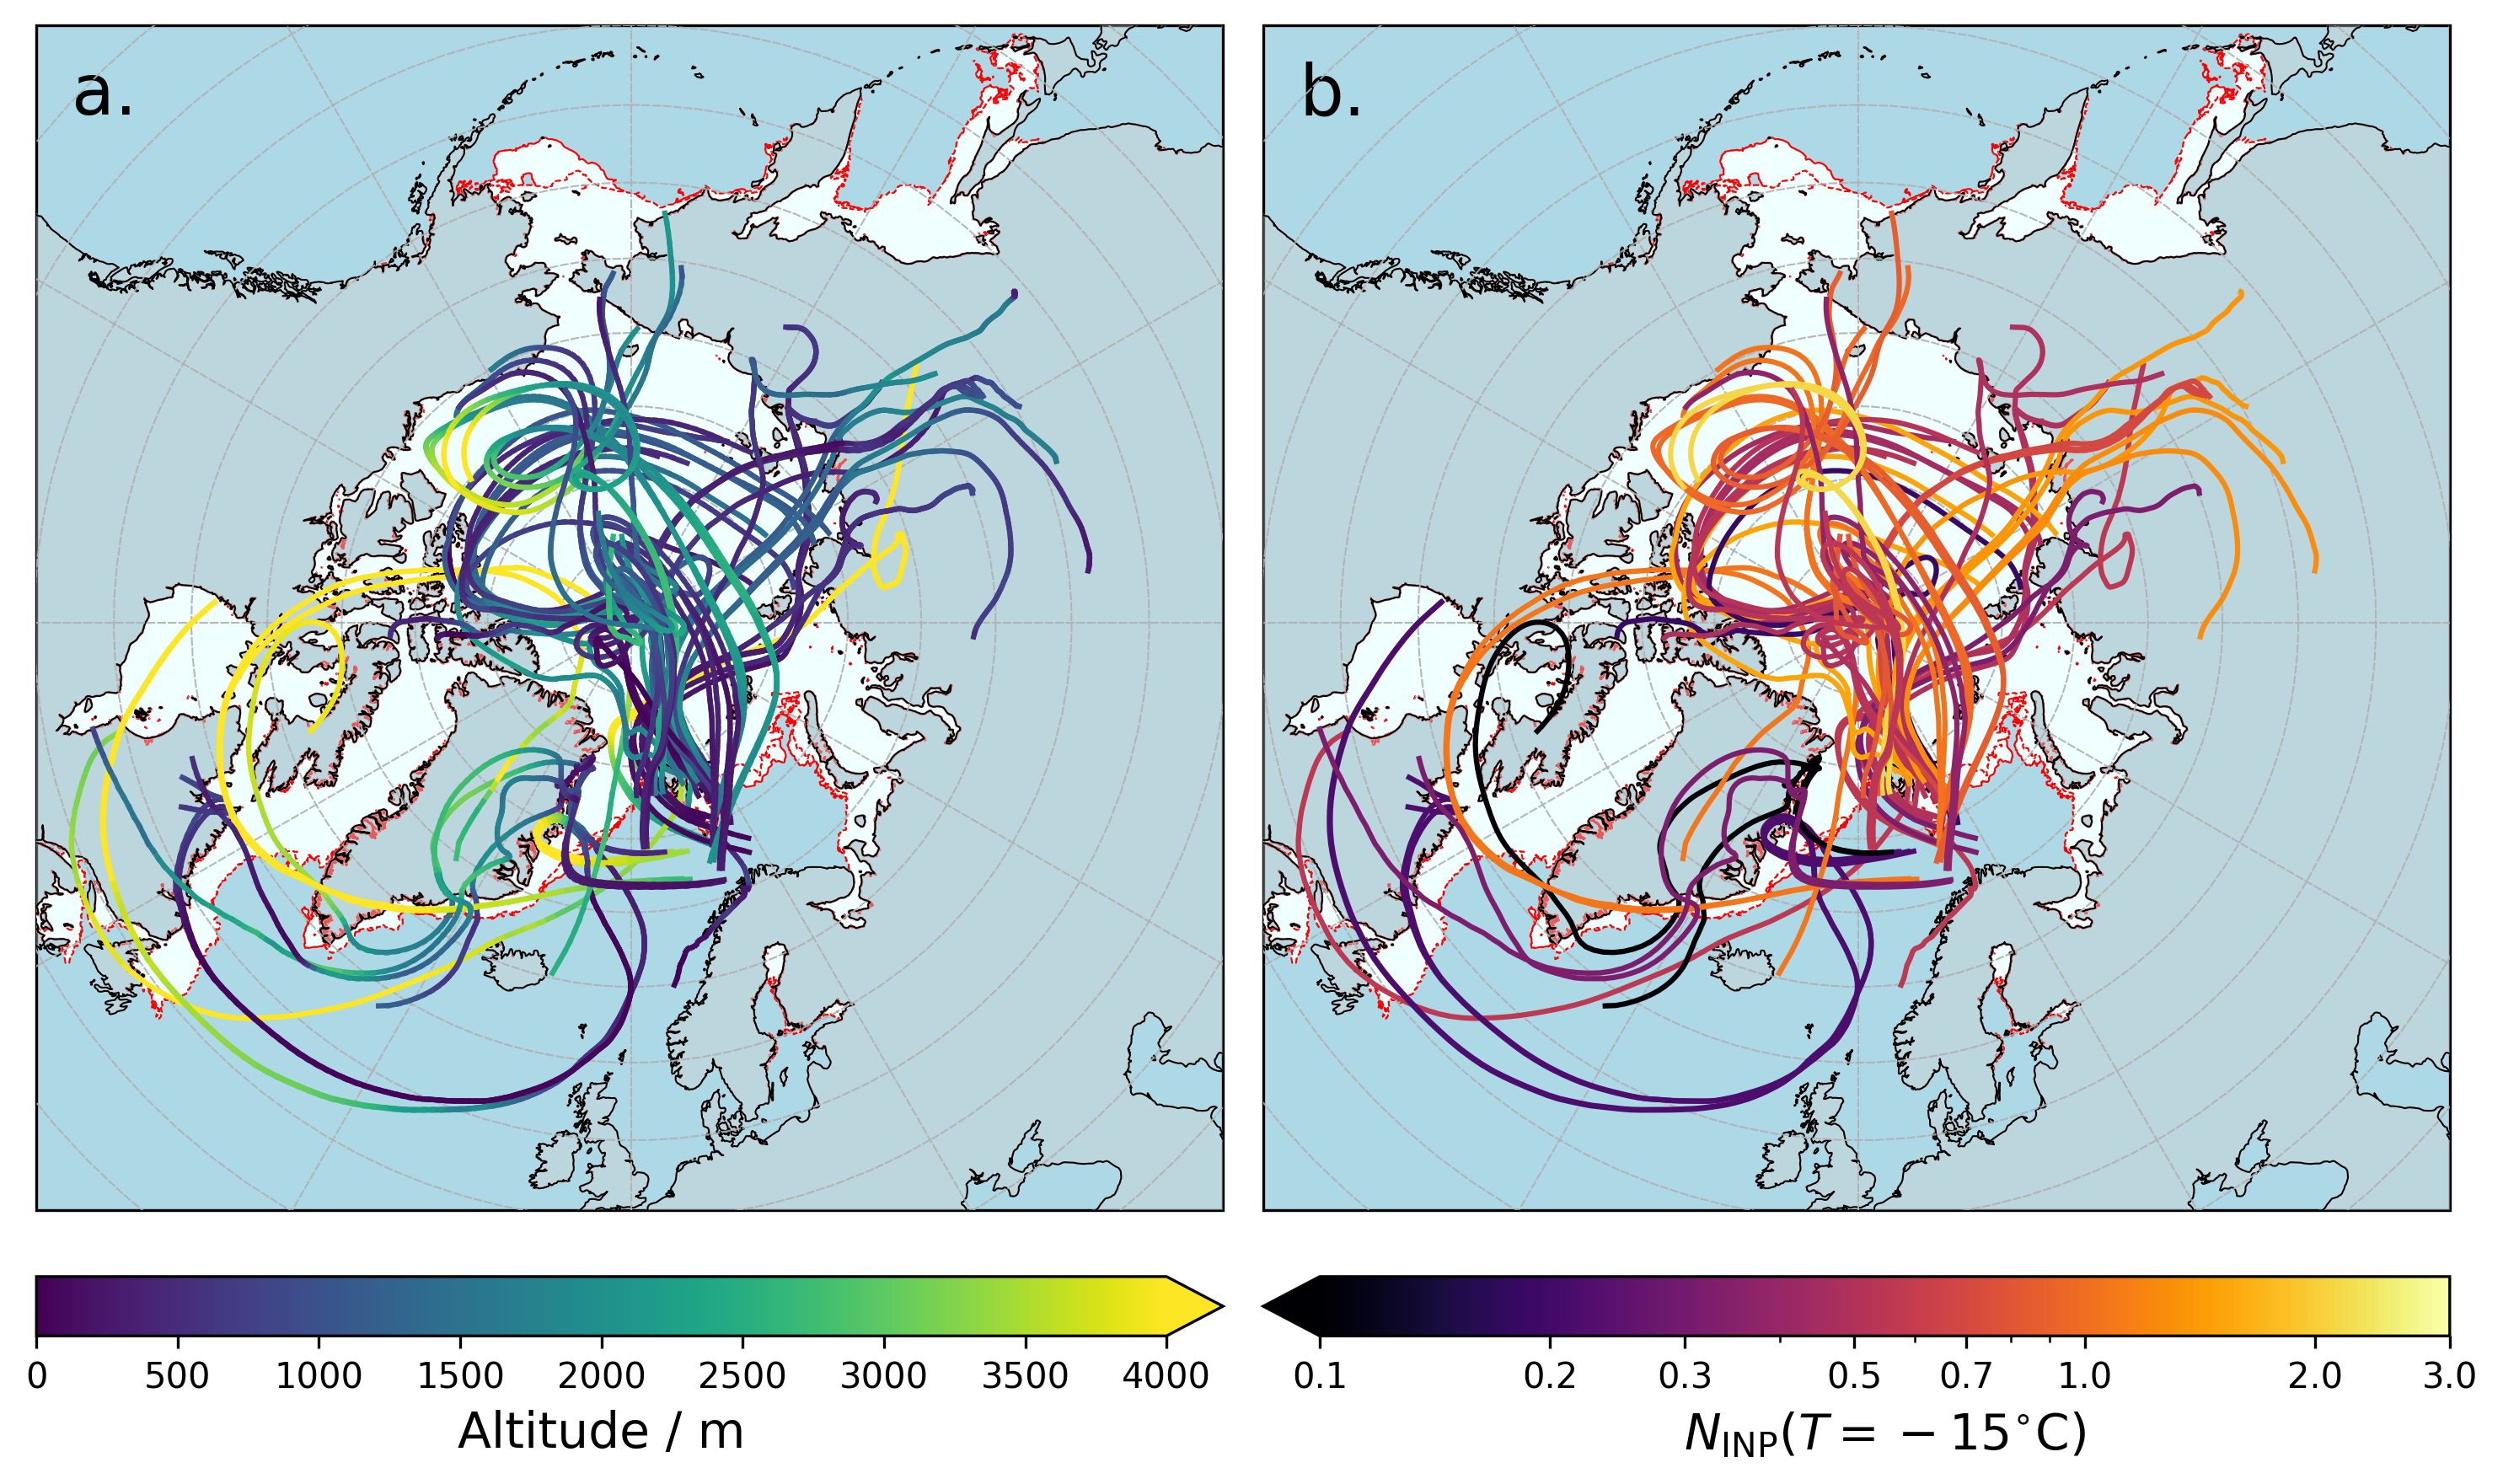

In [12]:
fig = plot_trajectories_for_n_days(7,add=True)
fig.savefig('./imgs/f11.png')